# `mammos_analysis` quickstart

`mammos_analysis` has a collection of post-processing tools:

- `mammos_analysis.hysteresis` contains functions to extract macroscopic properties from a hysteresis loop
- `mammos_analysis.kuzmin` contains fuctions to estimate micromagnetic properties from (atomistic) M(T) data using Kuz’min equations. 

In [1]:
import mammos_analysis
import mammos_entity as me
import mammos_units as u
import numpy as np

In [2]:
import matplotlib.pyplot as plt

## `mammos_analysis.hysteresis`

### Extrinsic properties Hc, Mr, BHmax

We can compute coercive field `Hc`, remanent magnetization `Mr` and the maximum energy product `BHmax` from a hysteresis loop.

We need to provide the external field `H` and the magnetization `M`. These could come from a simulation or experiment.
Here, we create some artificial data:

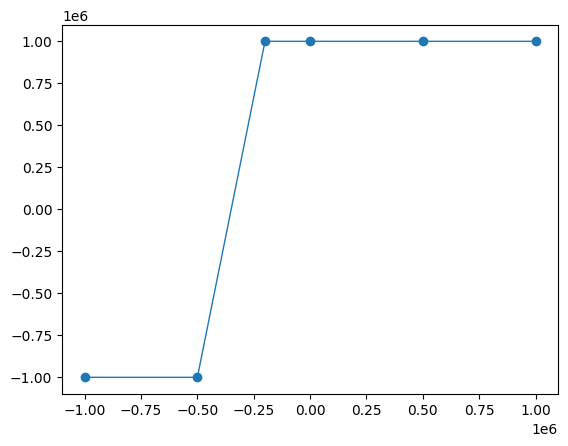

In [3]:
H = me.H([-1e6, -0.5e6, -0.2e6, 0, 0.5e6, 1e6])
M = me.M([-1e6, -1e6, 1e6, 1e6, 1e6, 1e6])
plt.plot(H.q, M.q, "o-", linewidth=1)

In [4]:
extrinsic_properties = mammos_analysis.hysteresis.extrinsic_properties(
    H=H,
    M=M,
    demagnetization_coefficient=1 / 3,  # assumption: we have a cube
)

In [5]:
extrinsic_properties.Mr

Entity(ontology_label='Remanence', value=np.float64(1000000.0), unit='A / m')

In [6]:
extrinsic_properties.Hc

Entity(ontology_label='CoercivityHcExternal', value=np.float64(350000.0), unit='A / m')

In [7]:
extrinsic_properties.BHmax  # only available if we pass a demagnetization_coefficient, otherwise NaN

Entity(ontology_label='MaximumEnergyProduct', value=np.float64(117286.12579786668), unit='A T / m')

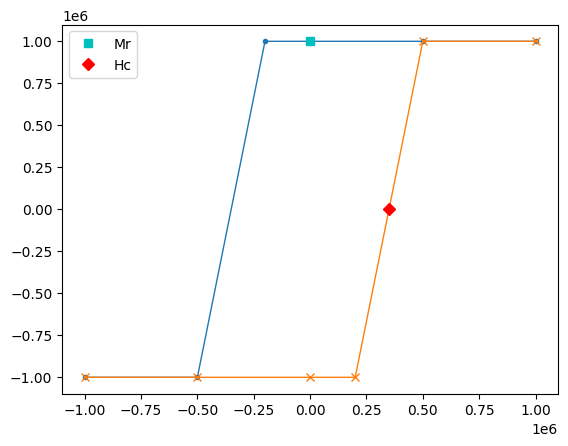

In [8]:
plt.plot(H.q, M.q, ".-", -H.q, -M.q, "x-", linewidth=1)
plt.plot(0, extrinsic_properties.Mr.q, "cs", label="Mr")
plt.plot(extrinsic_properties.Hc.q, 0, "rD", label="Hc")
plt.legend()

### Linear segment of a hysteresis loop

We can compute properties the linear segment (starting at H=0) of a hysteresis loop.

We need to provide the external field `H` and the magnetization `M`. These could come from a simulation or experiment. Here, we create some artificial data:

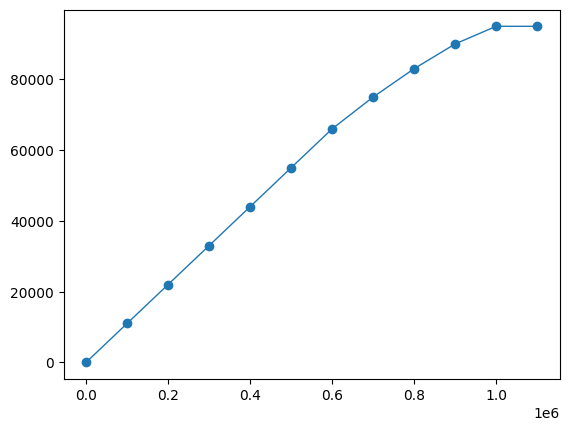

In [9]:
H = me.H(np.linspace(0, 1.1e6, 12))
M = me.M([0, 0.11e5, 0.22e5, 0.33e5, 0.44e5, 0.55e5, 0.66e5, 0.75e5, 0.83e5, 0.90e5, 0.95e5, 0.95e5])
plt.plot(H.q, M.q, "o-", linewidth=1)

In [10]:
margin = 0.03 * 0.95e5  # allow 3% maximum deviation from assumed Ms=0.95e5
linear_segment_properties = mammos_analysis.hysteresis.find_linear_segment(H=H, M=M, margin=margin, min_points=3)

<Axes: xlabel='External Magnetic Field (A / m)', ylabel='Spontaneous Magnetization (A / m)'>

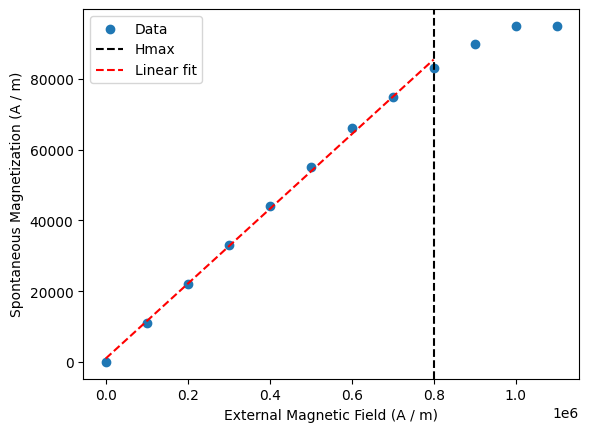

In [11]:
linear_segment_properties.plot()

## `mammos_analysis.kuzmin`

Functionality to extract estimated micromagnetic properties from Ms(T) data, which could e.g. come from spin dynamics simulations.

- We use Kuz’min equations to compute Ms(T), A(T), K1(T)
- Kuz’min, M.D., Skokov, K.P., Diop, L.B. et al. Exchange stiffness of ferromagnets. Eur. Phys. J. Plus 135, 301 (2020). https://doi.org/10.1140/epjp/s13360-020-00294-y
- Additional details about inputs and outputs are available in the [API reference](https://mammos-project.github.io/mammos/api/mammos_analysis.kuzmin.html#mammos_analysis.kuzmin.kuzmin_formula)

In this notebook we will use artificial data:

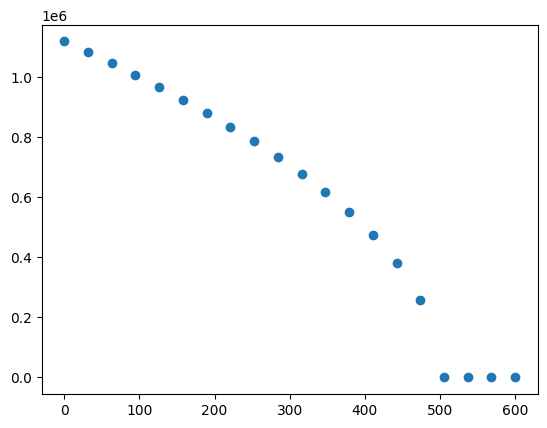

In [12]:
T = me.T(np.linspace(0, 600, 20))
Ms_val = np.sqrt(500 - T.value, where=T.value < 500, out=np.zeros_like(T.value)) * 0.5e5
Ms = me.Ms(Ms_val)
plt.plot(T.q, Ms.q, "o")

In [13]:
kuzmin_result = mammos_analysis.kuzmin.kuzmin_properties(T=T, Ms=Ms, K1_0=1e5)  # K1_0 is optional

We can visualize the resulting functions and compare against our input data:

array([<Axes: xlabel='Thermodynamic Temperature (K)', ylabel='Spontaneous Magnetization (A / m)'>,
       <Axes: xlabel='Thermodynamic Temperature (K)', ylabel='Exchange Stiffness Constant (J / m)'>,
       <Axes: xlabel='Thermodynamic Temperature (K)', ylabel='Uniaxial Anisotropy Constant (J / m3)'>],
      dtype=object)

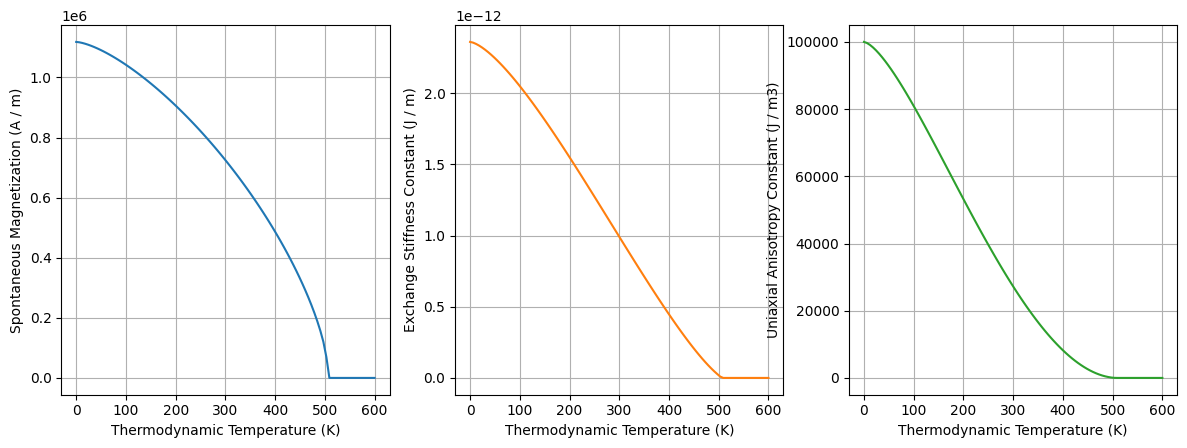

In [14]:
kuzmin_result.plot()

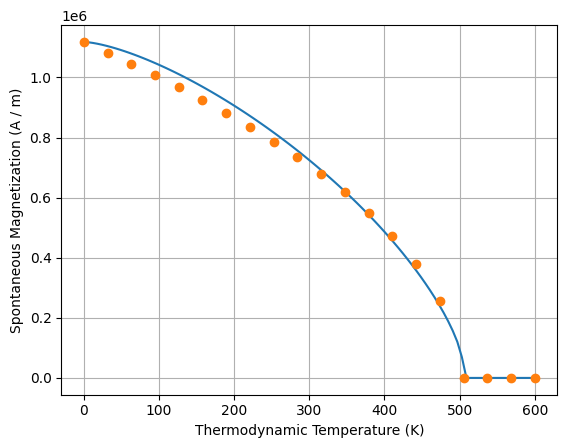

In [15]:
kuzmin_result.Ms.plot()
plt.plot(T.q, Ms.q, "o")

The result object contains three functions for Ms, A, and K1. K1 is only available if we pass `K1_0` to the `kuzmin_properties` function.
Furthermore, we get an estimated Curie temperature and the fit parameter s.

In [16]:
kuzmin_result

KuzminResult(Ms=Ms(T), A=A(T), Tc=Entity(ontology_label='CurieTemperature', value=np.float64(505.2631562509263), unit='K'), s=<Quantity 2.45341654>, K1=K1(T))

We can call the functions at different temperatures to get parameters. We can pass a `mammos_entity.Entity`, an `astropy.units.Quantity` or a number:

In [17]:
kuzmin_result.Ms(me.T(0))

Entity(ontology_label='SpontaneousMagnetization', value=np.float64(1118033.988749895), unit='A / m')

In [18]:
kuzmin_result.A(100 * u.K)

Entity(ontology_label='ExchangeStiffnessConstant', value=np.float64(2.049375691925977e-12), unit='J / m')

In [19]:
kuzmin_result.K1(300)

Entity(ontology_label='UniaxialAnisotropyConstant', value=np.float64(27234.48889604213), unit='J / m3')

We can also use an array to get data for multiple temperatures:

In [20]:
kuzmin_result.Ms(me.T([0, 100, 200, 300]))

Entity(ontology_label='SpontaneousMagnetization', value=array([1118033.9887499 , 1041900.28067714,  906082.21982426,
        724705.2646759 ]), unit='A / m')